## Install/import required libraries

In [ ]:
pip install diffusers transformers accelerate safetensors


make sure you have GPU access!

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

from diffusers import DiffusionPipeline


True
Tesla T4


#### If necessary, update with working huggingface write token

Go to huggingface.com/your_username -> settings -> access tokens -> create new token with WRITE permissions


In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `Smartwhales Image Gen` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Generating an image with NARW LoRA: example

In [ ]:
# !pip install -q transformers accelerate peft diffusers
from diffusers import DiffusionPipeline
import torch

pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.bfloat16).to("cuda")

pipe.load_lora_weights("henrysun9074/north-atlantic-right-whale-lora-mk-1", weight_name="north-atlantic-right-whale-lora-mk-1.safetensors", adapter_name="narw")
from diffusers import DPMSolverMultistepScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

prompt = "A drone photo of a north atlantic right whale swimming in the ocean"

lora_scale = 0.9
image = pipe(
    prompt, num_inference_steps=10, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Below: pipeline setup

(only run one depending on whether you're using DreamBooth or LoRA, comment out the other. the distinction is that dreambooth retrains the entire base model so you have to load in a wholly new model. LoRA takes a base model like SD1.0XL which you load in and then you specify the LoRA on top of that)

#### Pipeline setup for DreamBooth

In [ ]:
# from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
# import torch

# pipe = DiffusionPipeline.from_pretrained("henrysun9074/dreambooth-out", torch_dtype=torch.bfloat16).to("cuda")
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_attention_slicing()
# prompt = "a drone image of a humpback whale"

# image = pipe(prompt).images[0]
# image

#### Pipeline setup for LoRA

In [ ]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize pipeline
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.bfloat16).to("cuda")
# pipe.load_lora_weights("henrysun9074/HH-sdxl-lora-out", weight_name="pytorch_lora_weights.safetensors", adapter_name="humpback")
pipe.load_lora_weights("MaxTGH/Humpback-Whale-LoRA-SDXL-Test", weight_name="pytorch_lora_weights.safetensors", adapter_name="humpback")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

prompt = "a drone image of a humpback whale"
image = pipe(prompt, height=512, width=512).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Batch generation:  
Adjust total_images, num_inference_steps and batch_size and prompts as needed. Changing to a constant seed offset ensures reproducibility

Num_inference_steps is the amount of steps the model takes to go from a noised representation to a novel image output. Increasing this can increase generation quality but also jacks up the runtime.

In [ ]:
import random
prompt = "a drone image of a humpback whale"

def get_inputs(batch_size, seed_offset):
    generator = [torch.Generator("cuda").manual_seed(seed_offset + i) for i in range(batch_size)]
    # generator = torch.Generator(device="cuda")
    prompts = batch_size * [prompt]
    num_inference_steps = 30
    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

# Generate images in multiple batches
def generate_images(pipe, total_images, batch_size):
    all_images = []
    seed_offset = random.randint(0, 1_000_000) # For unique seeds across batches

    for _ in range(total_images // batch_size):
        inputs = get_inputs(batch_size, seed_offset)
        images = pipe(**inputs, height=512, width=512).images  #3648
        all_images.extend(images)

        # Free GPU memory
        torch.cuda.empty_cache()

        seed_offset += batch_size

    return all_images

total_images = 1
batch_size = 1
images = generate_images(pipe, total_images, batch_size)


  0%|          | 0/30 [00:00<?, ?it/s]

## Display images in a grid  


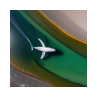

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def make_image_grid(images, rows, cols, scale_factor=2):
    # Resize images
    resized_images = [img.resize((img.width * scale_factor, img.height * scale_factor)) for img in images]

    img_width, img_height = resized_images[0].size
    grid_width = cols * img_width
    grid_height = rows * img_height

    # Create grid image
    grid = Image.new("RGB", (grid_width, grid_height))
    for i, img in enumerate(resized_images):
        grid.paste(img, box=(i % cols * img_width, i // cols * img_height))

    plt.figure(figsize=(cols, rows))
    plt.imshow(np.asarray(grid))
    plt.axis("off")
    plt.show()

dim = int(total_images/batch_size)
make_image_grid(images, dim, batch_size, scale_factor=2)  # Adjust scale_factor as needed


## Save Images to Google Drive  
Note: designed for Colab, modify with os to work with local machine

In [ ]:
import os
from PIL import Image
import zipfile
from google.colab import drive

save_path = '/content/drive/MyDrive/SmartWhalesCont/FakeImagery/Test1'
os.makedirs(save_path, exist_ok=True)

# Save each image
for idx, image in enumerate(images):
    filename = f'image_{idx}.png'
    image.save(os.path.join(save_path, filename))

print("✅ All images saved to:", save_path)

!ls "/content/drive/MyDrive/SmartWhalesCont/FakeImagery/Test1"


✅ All images saved to: /content/drive/MyDrive/SmartWhalesCont/FakeImagery/Test1
image_0.png
